# START HERE

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten,\
BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from skimage.transform import resize
from os import listdir, walk
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import pickle
import splitfolders

In [2]:
def fetch_files_names(directory):
    subfolders_path = [ f.name for f in os.scandir(directory) if f.is_dir() ]
    return subfolders_path

In [3]:
# directory of the base folder
dir = 'data/set_of_10/'
# Create a dictionary with mashrooms and labels TAKEN FROM KAGGLE PARTITION
CLASSES = {'Mycena_galericulata': 0,
 'Trametes_versicolor': 1,
 'Plicatura_crispa': 2,
 'Tremella_mesenterica': 3,
 'Hypholoma_fasciculare': 4,
 'Pluteus_cervinus': 5,
 'Meripilus_giganteus': 6,
 'Pleurotus_ostreatus': 7,
 'Russula': 8,
 'Stereum_hirsutum': 9}

In [4]:
# give the directory that includes folders of images and return three files split in train test validation

def split_data(dir = dir, output = dir + "/../output"):
    """
    Split data in train, test, validataion
    """
    splitfolders.ratio(dir , output=output, seed=1337, ratio=(.75, 0.15,0.1)) 


In [5]:
split_data()
train_path = dir + "/../output" + '/train/'
test_path = dir + "/../output" + '/test/'
valid_path = dir + "/../output" + '/val/'

Copying files: 11550 files [00:47, 242.72 files/s]


In [6]:
# prepare data for the model in batches to avoid RAM problems
train_datagen = ImageDataGenerator(rescale=1.0/255.0,validation_split=0.2) 

train_batches = train_datagen.flow_from_directory(directory=train_path, \
target_size=(224,224), classes=CLASSES, batch_size=16,subset='training',)

validation_batches = train_datagen.flow_from_directory(directory=train_path, \
target_size=(224,224), classes=CLASSES, batch_size=16,subset='validation',)

test_batches = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(\
directory=test_path, target_size=(224,224), classes=CLASSES, \
batch_size=16, shuffle=False,)


Found 6932 images belonging to 10 classes.
Found 1728 images belonging to 10 classes.
Found 1162 images belonging to 10 classes.


# MODEL ResNet50V2

In [7]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import os
from tensorflow.keras.models import Model
from tensorflow import keras

def model_ResNet50V2( learning_rate=0.001, cl = CLASSES):
    """
    This function returns a ResNet50V2 model with the last
    layer removed.
    """
    K.clear_session() # Always clear the session!

    base_model = ResNet50V2(
        weights='imagenet', 
        pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
        include_top=False,   # !!!!! we only want to have the base, not the final dense layers 
        input_shape=(224, 224, 3)  
    )
    base_model.trainable = False # To freeze the model
    # Start building on top of the model
    model = keras.Sequential() # defining a new model
    model.add(base_model) # adding in the pretrained model without the fully connected layer
    model.add(keras.layers.Dense(64, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(len(cl), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
    # have a look at the trainable and non-trainable params statistic
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

def fit_ResNet50V2(train_batches=train_batches,validation_data =validation_batches,epochs = 200, sav = True):
    """
    This function fits the model on the training data.
    """
    # observe the validation loss and stop when it does not improve after 3 iterations
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit( x=train_batches,
            epochs=epochs, 
            verbose=1, 
            callbacks=[callback],
            validation_data = validation_data, )
    
    # save model
    if sav == True:
        model.save('models/ResNet50V2.h5') 
    return model, history


In [ ]:
model = model_ResNet50V2(learning_rate=0.001)
model, history = fit_ResNet50V2(epochs = 200)

# Mobilinet

In [ ]:
# Model MobileNetV2
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import os
from tensorflow.keras.models import Model
from tensorflow import keras

def model_MobileNetV2( learning_rate=0.001, cl = CLASSES):
    """
    This function returns a ResNet50V2 model with the last
    layer removed.
    """
    K.clear_session() # Always clear the session!

    base_model = MobileNetV2(
        weights='imagenet', 
        pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
        include_top=False,   # !!!!! we only want to have the base, not the final dense layers 
        input_shape=(224, 224, 3)  
    )
    base_model.trainable = False # To freeze the model
    # Start building on top of the model
    model = keras.Sequential() # defining a new model
    model.add(base_model) # adding in the pretrained model without the fully connected layer
    model.add(keras.layers.Dense(64, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(len(cl), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
    # have a look at the trainable and non-trainable params statistic
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

def fit_MobileNetV2(train_batches=train_batches,validation_data =validation_batches,epochs = 200, sav = True):
    """
    This function fits the model on the training data.
    """
    # observe the validation loss and stop when it does not improve after 3 iterations
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit( x=train_batches,
            epochs=epochs, 
            verbose=1, 
            callbacks=[callback],
            validation_data = validation_data, )
    
    # save model
    if sav == True:
        model.save('models/MobileNetV2.h5') 
    return model, history


In [ ]:
model = model_MobileNetV2(learning_rate=0.001)
model, history = fit_MobileNetV2(epochs = 200)

# EfficientNetB7

In [386]:
# Model MobileNetV2
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import os
from tensorflow.keras.models import Model
from tensorflow import keras

def model_InceptionResNetV2( learning_rate=0.001, cl = CLASSES):
    """
    This function returns a ResNet50V2 model with the last
    layer removed.
    """
    K.clear_session() # Always clear the session!

    base_model = InceptionResNetV2(
        weights='imagenet', 
        pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
        include_top=False,   # !!!!! we only want to have the base, not the final dense layers 
        input_shape=(224, 224, 3)  
    )
    base_model.trainable = False # To freeze the model
    # Start building on top of the model
    model = keras.Sequential() # defining a new model
    model.add(base_model) # adding in the pretrained model without the fully connected layer
    model.add(keras.layers.Dense(64, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(len(cl), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
    # have a look at the trainable and non-trainable params statistic
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

def fit_InceptionResNetV2(train_batches=train_batches,validation_data =validation_batches,epochs = 200, sav = True):
    """
    This function fits the model on the training data.
    """
    # observe the validation loss and stop when it does not improve after 3 iterations
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit( x=train_batches,
            epochs=epochs, 
            verbose=1, 
            callbacks=[callback],
            validation_data = validation_data, )
    
    # save model
    if sav == True:
        model.save('models/InceptionResNetV2_test.h5') 
    return model, history


In [ ]:
model = model_InceptionResNetV2(learning_rate=0.001)
model, history = fit_InceptionResNetV2(epochs = 200)

# Tensorboard- ResNet

In [392]:
from tensorflow.keras.callbacks import TensorBoard as tsb

In [400]:
# test tensorboard

    
def model_ResNet50V2(cl, learning_rate=0.001  ):
    """
    This function returns a ResNet50V2 model with the last
    layer removed.
    """
    # Always clear the session!
    K.clear_session() 
    base_model = ResNet50V2(
        weights='imagenet', 
        pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
        include_top=False,   # !!!!! we only want to have the base, not the final dense layers 
        input_shape=(224, 224, 3)  
    )
    base_model.trainable = False # To freeze the model
    # Start building on top of the model
    model = keras.Sequential() # defining a new model
    model.add(base_model) # adding in the pretrained model without the fully connected layer
    model.add(keras.layers.Dense(64, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(256, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(len(cl), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
    # have a look at the trainable and non-trainable params statistic
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])
    
    tensorboard_callback = tsb(
        log_dir = './tb_callback_dir', histogram_freq = 1,
    )
    return model, tensorboard_callback

def fit_ResNet50V2(train_batches,validation_data ,tensorboard_callback, epochs = 200, sav = True ):
    """
    This function fits the model on the training data.
    """
    # observe the validation loss and stop when it does not improve after 3 iterations
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit( x=train_batches,
            epochs=epochs, 
            verbose=1, 
            callbacks=[tensorboard_callback],
            validation_data = validation_data, )
    return model, history
    


In [401]:
model, tensorboard_callback = model_ResNet50V2(cl = CLASSES,learning_rate=0.0001)
model, history = fit_ResNet50V2(train_batches=train_batches,validation_data =validation_batches,tensorboard_callback =tensorboard_callback ,epochs =15)

2022-06-05 05:17:46.292503: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_11 in the registry.
Traceback (most recent call last):

  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 259, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_11 in the registry.


2022-06-05 05:17:46.295155: W tensorflow/core/kernels/data/generator_dataset_op.cc:107] Error occurred when finalizing GeneratorDataset iterator: INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_11 in the registry.
Traceback (most recent call last):

  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 259, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_11 in the registry.


	 [[{{nod

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

2022-06-05 05:36:11.869388: W tensorflow/core/framework/op_kernel.cc:1733] UNKNOWN: OSError: image file is truncated (95 bytes not processed)
Traceback (most recent call last):

  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/anaconda3/lib/python3.7/site-packages/keras/engine/data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "/opt/anaconda3/lib/python3.7/site-packages/keras/engine/data_adapter.py", line 956, in generator_fn
    yield x[i]

  File "/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/iter

UnknownError: Graph execution error:

OSError: image file is truncated (95 bytes not processed)
Traceback (most recent call last):

  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/anaconda3/lib/python3.7/site-packages/keras/engine/data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "/opt/anaconda3/lib/python3.7/site-packages/keras/engine/data_adapter.py", line 956, in generator_fn
    yield x[i]

  File "/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)

  File "/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py", line 138, in load_img
    img = img.resize(width_height_tuple, resample)

  File "/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 1961, in resize
    self.load()

  File "/opt/anaconda3/lib/python3.7/site-packages/PIL/ImageFile.py", line 248, in load
    "image file is truncated "

OSError: image file is truncated (95 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_test_function_210055]

# Evaluate model

In [8]:
def plot_history(history):
    losses_accurs = pd.DataFrame(history)
    
    losses_accurs[['loss', 'val_loss']].plot()
    plt.title('Train and Test (val) Loss')
    plt.xlabel('epochs')
    plt.show()

    losses_accurs[['categorical_accuracy', 'val_categorical_accuracy']].plot()
    plt.title('Train and Test (val) Accuracy')
    plt.xlabel('epochs')
    plt.show()

In [50]:
def evaluate(model_dir):
    model=keras.models.load_model("models/" + model_dir + ".h5")
    history = pd.read_csv('models/history_' + model_dir + '.csv')
    #plot_history(history)
    acc = history.tail(1)
    print(f"The model has an accuracy of {int(round(acc['val_categorical_accuracy'].values[0],2)*100)} %.")
    return history, acc, model
    

# models
- ResNet
- - ResNet50V2_2la_0001r_60bs_10set
- - ResNet50V2_3la_0001r_60bs_10set
- - ResNet50V2_3la_001r_60bs_10set
- InceptionResNetV2
- - InceptionResNetV2_2la_0001r_60bs_10set
- - InceptionResNetV2_3la_0001r_60bs_10set
- MobilieNetV2
- - MobileNetV2_2la_0001r_60bs_10set
- - MobileNetV2_3la_0001r_60bs_10set
- - MobileNetV2_4la_001r_60bs_sm


In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
ResNet = ['ResNet50V2_2la_0001r_60bs_10set', 'ResNet50V2_3la_0001r_60bs_10set','ResNet50V2_3la_001r_60bs_10set']
InceptionNet = ['InceptionResNetV2_2la_0001r_60bs_10set', 'InceptionResNetV2_3la_0001r_60bs_10set']
MobileNet = ['MobileNetV2_2la_0001r_60bs_10set', 'MobileNetV2_3la_0001r_60bs_10set','MobileNetV2_4la_001r_60bs_sm']

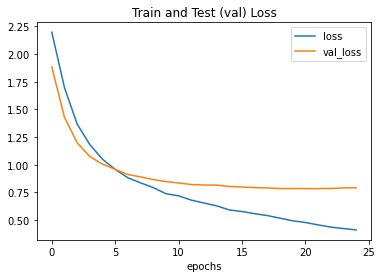

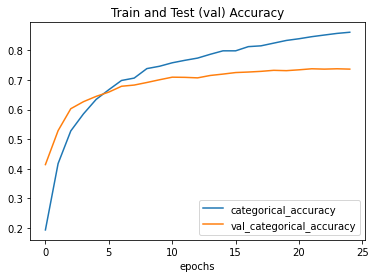

The model has an accuracy of 74 %.


,loss,categorical_accuracy,val_loss,val_categorical_accuracy
Unnamed: 0,,,,
0,2.196789,0.193739,1.883263,0.414352
1,1.696936,0.417773,1.428641,0.528935
2,1.367438,0.527986,1.199096,0.603009
3,1.181812,0.585545,1.073401,0.626736
4,1.049413,0.634449,1.005605,0.644676
5,0.958010,0.667196,0.957527,0.659144
6,0.882208,0.698355,0.911943,0.678819
7,0.836175,0.706434,0.889813,0.682870
8,0.793578,0.738459,0.866306,0.691551


In [44]:
t = pd.DataFrame(evaluate('ResNet50V2_2la_0001r_60bs_10set')[0].set_index('Unnamed: 0'))
t

In [62]:
ResNet[0]

'ResNet50V2_2la_0001r_60bs_10set'

In [79]:
def make_frame(model,i):
    """
    make a data frame with the data 
    """
    history = evaluate(model)[0]
    losses_accurs = pd.DataFrame(history)
    model_name = model.split('_')[0]
    losses_accurs['model_name'] = model_name
    losses_accurs['model_number'] = i
    losses_accurs['epoch'] = np.arange(0,len(losses_accurs))
    return losses_accurs

        

# Compare tunning for each model

In [113]:
# Concatenate the different frames
df1 = make_frame(ResNet[0],1)
df2 = make_frame(ResNet[1],2)
df3 = make_frame(ResNet[2],3)
df_ResNet = pd.concat([df1,df2,df3],ignore_index=True).drop(columns=['Unnamed: 0'])


The model has an accuracy of 74 %.
The model has an accuracy of 73 %.
The model has an accuracy of 71 %.


In [114]:
df1

,Unnamed: 0,loss,categorical_accuracy,val_loss,val_categorical_accuracy,model_name,model_number,epoch
0,0,2.196789,0.193739,1.883263,0.414352,ResNet50V2,1,0
1,1,1.696936,0.417773,1.428641,0.528935,ResNet50V2,1,1
2,2,1.367438,0.527986,1.199096,0.603009,ResNet50V2,1,2
3,3,1.181812,0.585545,1.073401,0.626736,ResNet50V2,1,3
4,4,1.049413,0.634449,1.005605,0.644676,ResNet50V2,1,4
5,5,0.958010,0.667196,0.957527,0.659144,ResNet50V2,1,5
6,6,0.882208,0.698355,0.911943,0.678819,ResNet50V2,1,6
7,7,0.836175,0.706434,0.889813,0.682870,ResNet50V2,1,7
8,8,0.793578,0.738459,0.866306,0.691551,ResNet50V2,1,8
9,9,0.738318,0.746394,0.847471,0.700810,ResNet50V2,1,9


In [87]:
df_ResNet.tail(3)


,loss,categorical_accuracy,val_loss,val_categorical_accuracy,model_name,model_number,epoch
49,0.592146,0.797461,0.902499,0.710648,ResNet50V2,3,3
50,0.518993,0.821985,0.958190,0.708912,ResNet50V2,3,4
51,0.433936,0.855164,1.041591,0.707176,ResNet50V2,3,5


ResNet50V2_2la_0001r_60bs_10set', 'ResNet50V2_3la_0001r_60bs_10set','ResNet50V2_3la_001r_60bs_10set'

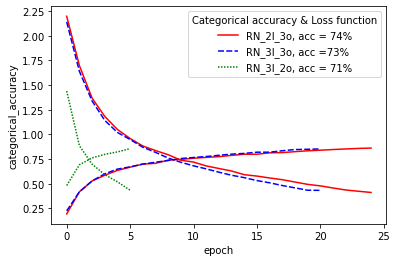

In [94]:
sns.lineplot(data=df_ResNet, x = 'epoch', y = 'categorical_accuracy',  hue = 'model_number',style='model_number',palette=['red', 'blue','green'])
sns.lineplot(data=df_ResNet, x = 'epoch', y = 'loss',  hue = 'model_number',style='model_number',palette=['red', 'blue','green'])
plt.legend(title='Categorical accuracy & Loss function', loc='upper right', labels=['RN_2l_3o, acc = 74%','RN_3l_3o, acc =73%','RN_3l_2o, acc = 71%'])



'MobileNetV2_2la_0001r_60bs_10set', 'MobileNetV2_3la_0001r_60bs_10set','MobileNetV2_4la_001r_60bs_sm'

In [95]:
# Concatenate the different frames
df1 = make_frame(MobileNet[0],1)
df2 = make_frame(MobileNet[1],2)
df3 = make_frame(MobileNet[2],3)
df_MN = pd.concat([df1,df2,df3],ignore_index=True).drop(columns=['Unnamed: 0'])

The model has an accuracy of 73 %.
The model has an accuracy of 76 %.
The model has an accuracy of 72 %.


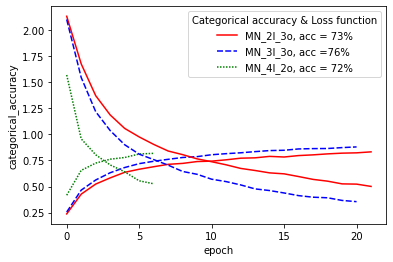

In [96]:
sns.lineplot(data=df_MN, x = 'epoch', y = 'categorical_accuracy',  hue = 'model_number',style='model_number',palette=['red', 'blue','green'])
sns.lineplot(data=df_MN, x = 'epoch', y = 'loss',  hue = 'model_number',style='model_number',palette=['red', 'blue','green'])
plt.legend(title='Categorical accuracy & Loss function', loc='upper right', labels=['MN_2l_3o, acc = 73%','MN_3l_3o, acc =76%','MN_4l_2o, acc = 72%'])


'InceptionResNetV2_2la_0001r_60bs_10set', 'InceptionResNetV2_3la_0001r_60bs_10set'

In [99]:
# Concatenate the different frames
df1 = make_frame(InceptionNet[0],1)
df2 = make_frame(InceptionNet[1],2)
df_IN = pd.concat([df1,df2],ignore_index=True).drop(columns=['Unnamed: 0'])

The model has an accuracy of 71 %.
The model has an accuracy of 70 %.


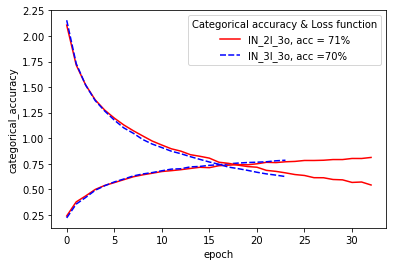

In [101]:
sns.lineplot(data=df_IN, x = 'epoch', y = 'categorical_accuracy',  hue = 'model_number',style='model_number',palette=['red', 'blue'])
sns.lineplot(data=df_IN, x = 'epoch', y = 'loss',  hue = 'model_number',style='model_number',palette=['red', 'blue'])
plt.legend(title='Categorical accuracy & Loss function', loc='upper right', labels=['IN_2l_3o, acc = 71%','IN_3l_3o, acc =70%'])


- END

# Compare best tunnings from the three models

In [102]:
df1 = make_frame(InceptionNet[0],1)
df2 = make_frame(MobileNet[1],2)
df3 = make_frame(ResNet[0],1)
df_compare_models = pd.concat([df1,df2,df3],ignore_index=True).drop(columns=['Unnamed: 0'])

The model has an accuracy of 71 %.
The model has an accuracy of 76 %.
The model has an accuracy of 74 %.


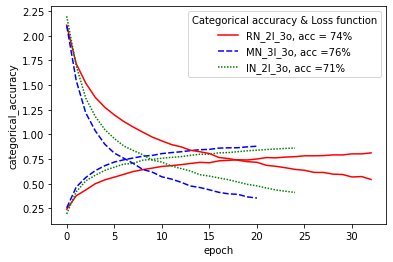

In [106]:
sns.lineplot(data=df_compare_models, x = 'epoch', y = 'categorical_accuracy',  hue = 'model_name',style='model_name',palette=['red', 'blue', 'green'])
sns.lineplot(data=df_compare_models, x = 'epoch', y = 'loss',  hue = 'model_name',style='model_name',palette=['red', 'blue', 'green'])
plt.legend(title='Categorical accuracy & Loss function', loc='upper right', labels=['RN_2l_3o, acc = 74%','MN_3l_3o, acc =76%','IN_2l_3o, acc =71%'])


# Compare train validate values for MobileNet[1],2)

In [107]:
MN = make_frame(MobileNet[1],2)

The model has an accuracy of 76 %.


In [108]:
MN

,Unnamed: 0,loss,categorical_accuracy,val_loss,val_categorical_accuracy,model_name,model_number,epoch
0,0,2.102569,0.254616,1.739946,0.450231,MobileNetV2,2,0
1,1,1.546043,0.465089,1.220833,0.604167,MobileNetV2,2,1
2,2,1.218250,0.562464,1.015491,0.653356,MobileNetV2,2,2
3,3,1.036678,0.631997,0.904052,0.675347,MobileNetV2,2,3
4,4,0.900777,0.682054,0.844246,0.697917,MobileNetV2,2,4
5,5,0.810199,0.719273,0.801625,0.708912,MobileNetV2,2,5
6,6,0.758266,0.742066,0.771161,0.718750,MobileNetV2,2,6
7,7,0.704976,0.760819,0.752209,0.726852,MobileNetV2,2,7
8,8,0.644251,0.778419,0.739246,0.732639,MobileNetV2,2,8
9,9,0.617081,0.786642,0.717828,0.736111,MobileNetV2,2,9


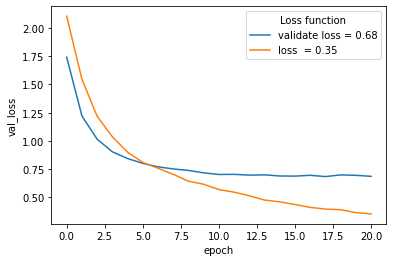

In [116]:
sns.lineplot(data=MN, x = 'epoch', y = 'val_loss',palette=['red',  'green'])
sns.lineplot(data=MN, x = 'epoch', y = 'loss'  ,palette=['red',  'green'])
plt.legend(title='Loss function', loc='upper right', labels=['validate loss = 0.68','loss  = 0.35'])

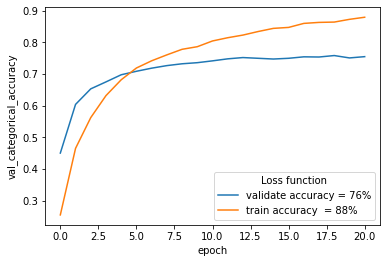

In [118]:
sns.lineplot(data=MN, x = 'epoch', y = 'val_categorical_accuracy',palette=['red',  'green'])
sns.lineplot(data=MN, x = 'epoch', y = 'categorical_accuracy'  ,palette=['red',  'green'])
plt.legend(title='Loss function', loc='lower right', labels=['validate accuracy = 76%','train accuracy  = 88%'])

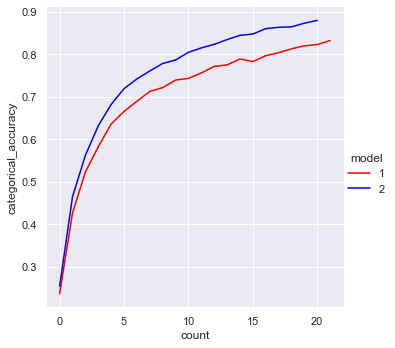

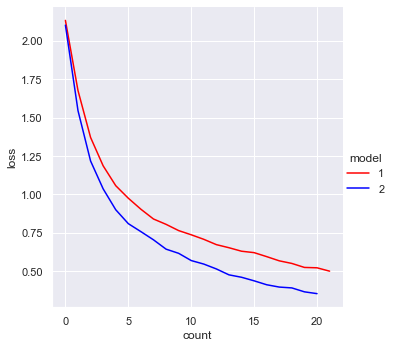

In [373]:
#data=df.melt(id_vars=["x-axis", "group", "group2"], value_vars=["col1", "col2"])
sns.relplot(data=df, x = 'count', y = 'categorical_accuracy', kind = 'line', hue = 'model', palette = ['red', 'blue'])
sns.relplot(data=df, x = 'count', y = 'loss', kind = 'line', hue = 'model', palette = ['red', 'blue'])


/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


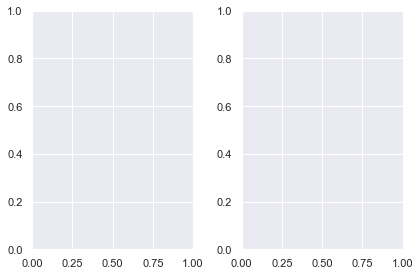

In [382]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0]
axs[1].plot(x, -y)
g1 = sns.relplot(data=df, x = 'count', y = 'categorical_accuracy',  hue = 'model',style='model',palette=['red', 'blue'], ax=ax[0])
g2 = sns.relplot(data=df, x = 'count', y = 'loss',  hue = 'model',style='model',palette=['green', 'black'], ax=ax[1])
plt.close(g1.fig)
plt.close(g2.fig) 
plt.tight_layout()

<AxesSubplot:xlabel='count', ylabel='categorical_accuracy'>

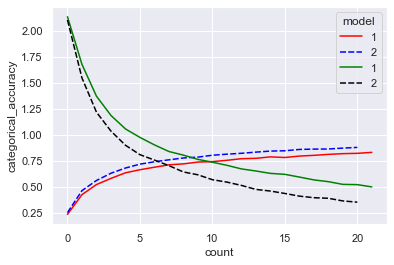

In [378]:
sns.lineplot(data=df, x = 'count', y = 'categorical_accuracy',  hue = 'model',style='model',palette=['red', 'blue'])
sns.lineplot(data=df, x = 'count', y = 'loss',  hue = 'model',style='model',palette=['green', 'black'])


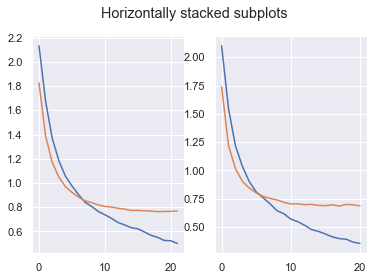

In [383]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot(losses_accurs[['loss', 'val_loss']])
ax2.plot(losses_accurs1[['loss', 'val_loss']])

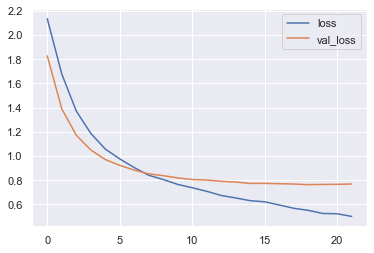

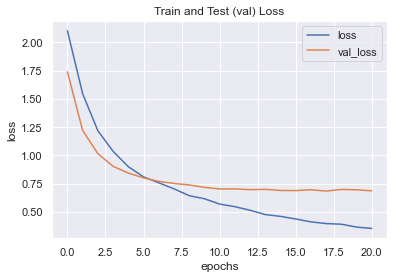

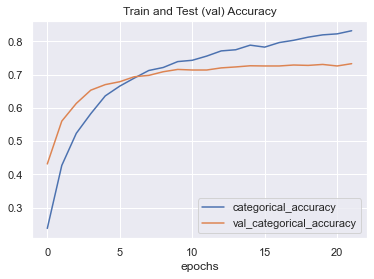

In [353]:
# test comparing models
losses_accurs = pd.DataFrame(history)
losses_accurs1 = pd.DataFrame(history1)
losses_accurs[['loss', 'val_loss']].plot()
losses_accurs1[['loss', 'val_loss']].plot()
plt.title('Train and Test (val) Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
losses_accurs[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title('Train and Test (val) Accuracy')
plt.xlabel('epochs')
plt.show()

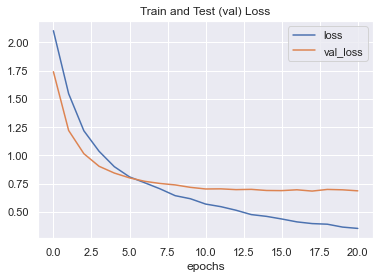

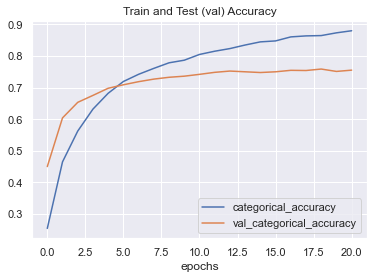

The model has an accuracy of 76 %.


In [352]:
history1, acc1, model1 = evaluate('MobileNetV2_3la_0001r_60bs_10set')

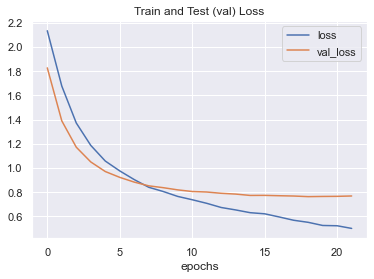

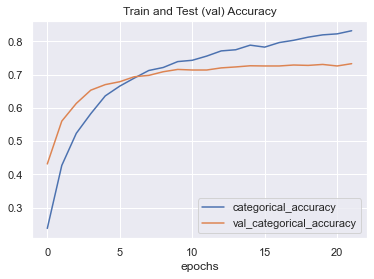

The model has an accuracy of 73 %.


In [347]:
history, acc, model = evaluate('MobileNetV2_2la_0001r_60bs_10set')


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# you could either use this custom function or the built in function from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

In [ ]:
test_batches = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(\
directory=test_path, target_size=(224,224), classes=['cats', 'dogs'], \
batch_size=64, shuffle=False)

# Prediction

In [402]:
def fetch_image(subdirectory):
    onlyfiles = [f for f in listdir(subdirectory) if isfile(join(subdirectory, f))]
    #label = np.full((1, len(onlyfiles)), get_label(onlyfiles))#.ravel()
    return onlyfiles

In [470]:
def image_classification(image_path):
    image = keras.preprocessing.image.load_img(image_path, target_size=(224,224))
    pic_array = keras.preprocessing.image.img_to_array(image)
    image_batch = np.expand_dims(pic_array, axis=0)
    processed_image = keras.applications.mobilenet_v2.preprocess_input(image_batch)
    model=keras.models.load_model("models/" + 'ResNet50V2_2la_0001r_60bs_10set' + ".h5")
    probs = model.predict(processed_image)[0].tolist()
    zipped = sorted(list(zip(CLASSES, probs)), key=lambda x: x[1], reverse=True)
    image_class = [zipped[i][0] for i in range(len(zipped))]
    probability  = [zipped[i][1]*100 for i in range(len(zipped))]
    #df = pd.DataFrame(data={'image_class':image_class, 'probability(%)': probability})
    df = pd.DataFrame({'mushroom':image_class, 'probability(%)':probability})
    return df


In [492]:
def choose_test_file(direct = 'data/test/', model = model):
    image_dir = direct + random.choice(os.listdir(direct))
    item = cv2.imread(image_dir)
    plt.imshow(item,cmap='Greys')
    dataFrame = image_classification(image_dir)
    NMF_movies = dataFrame.values.tolist()[:5]
    return NMF_movies, dataFrame
    

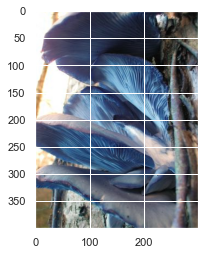

In [493]:
l, m = choose_test_file()

In [504]:
def mushroom_depict():
    """
    returns the image of test mushroom
    """
    direct = './data/test/'
    image_dir = direct + random.choice(os.listdir(direct))
    item = cv2.imread(image_dir)
    img_show = plt.imshow(item,cmap='Greys')

    return img_show


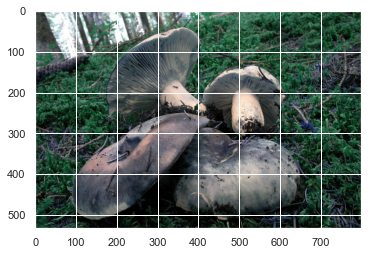

In [506]:
mushroom_depict()